<a href="https://colab.research.google.com/github/Ruma13/skin_cancer-tl/blob/main/resnet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50


In [ ]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Dataset/train'
train_df = loading_the_data(data_dir)
train_df

,filepaths,labels
0,/content/drive/MyDrive/Colab Dataset/train/mal...,malignant
1,/content/drive/MyDrive/Colab Dataset/train/mal...,malignant
2,/content/drive/MyDrive/Colab Dataset/train/mal...,malignant
3,/content/drive/MyDrive/Colab Dataset/train/mal...,malignant
4,/content/drive/MyDrive/Colab Dataset/train/mal...,malignant
...,...,...
2632,/content/drive/MyDrive/Colab Dataset/train/ben...,benign
2633,/content/drive/MyDrive/Colab Dataset/train/ben...,benign
2634,/content/drive/MyDrive/Colab Dataset/train/ben...,benign
2635,/content/drive/MyDrive/Colab Dataset/train/ben...,benign


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Dataset/test'
ts_df = loading_the_data(data_dir)
ts_df


,filepaths,labels
0,/content/drive/MyDrive/Colab Dataset/test/beni...,benign
1,/content/drive/MyDrive/Colab Dataset/test/beni...,benign
2,/content/drive/MyDrive/Colab Dataset/test/beni...,benign
3,/content/drive/MyDrive/Colab Dataset/test/beni...,benign
4,/content/drive/MyDrive/Colab Dataset/test/beni...,benign
...,...,...
655,/content/drive/MyDrive/Colab Dataset/test/mali...,malignant
656,/content/drive/MyDrive/Colab Dataset/test/mali...,malignant
657,/content/drive/MyDrive/Colab Dataset/test/mali...,malignant
658,/content/drive/MyDrive/Colab Dataset/test/mali...,malignant


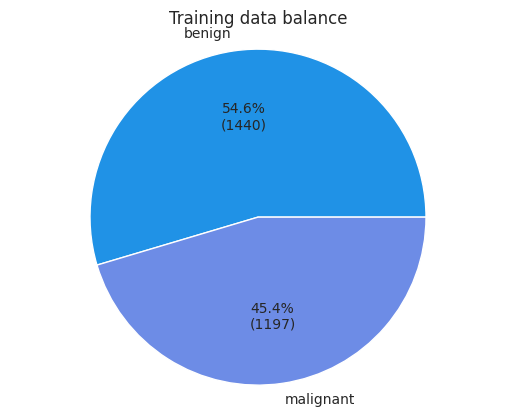

In [ ]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [ ]:
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
batch_size = 8
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


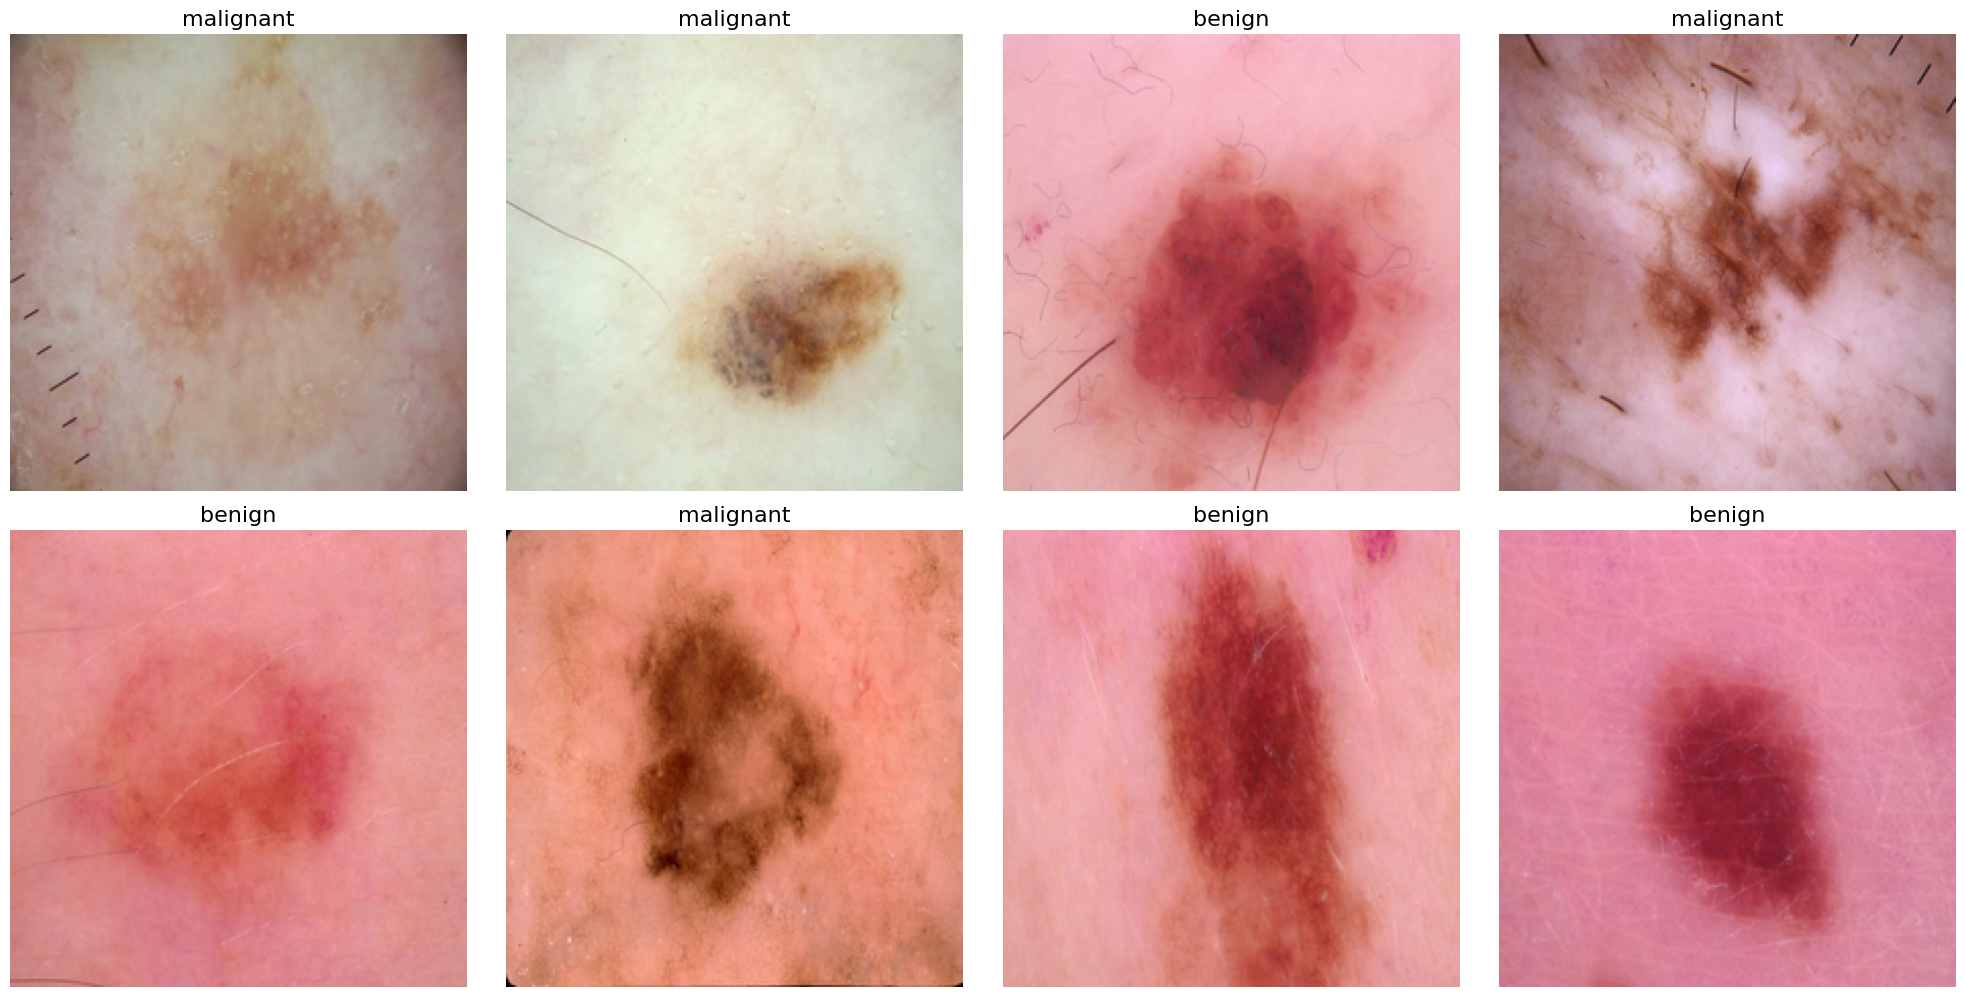

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)


plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

def plot_confusion_matrix(model, test_gen):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]))
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

for layer in base_model.layers:
    if 'conv5_block3' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)

ResNet50_model = Model(inputs = base_model.input, outputs = predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
for layer in ResNet50_model.layers:
    print(layer.name, layer.trainable)s

input_layer False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2

In [ ]:
ResNet50_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

ResNet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,862,370 (91.03 MB)

 Trainable params: 4,736,226 (18.07 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

In [ ]:
epochs = 15

ResNet50_history = ResNet50_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 1222s 4s/step - accuracy: 0.7399 - loss: 0.5491 - val_accuracy: 0.5030 - val_loss: 0.8827
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.7883 - loss: 0.4538 - val_accuracy: 0.8000 - val_loss: 0.4072
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.8003 - loss: 0.4166 - val_accuracy: 0.8121 - val_loss: 0.4349
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.8258 - loss: 0.3788 - val_accuracy: 0.8303 - val_loss: 0.3721
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.8188 - loss: 0.4002 - val_accuracy: 0.8061 - val_loss: 0.4597
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.8256 - loss: 0.3758 - val_accuracy: 0.7576 - val_loss: 0.6288
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.8288 - loss: 0.3722 - val_accuracy: 0.8485 - val_loss: 0.3648
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.8401 - loss: 0.3671 - val_acc

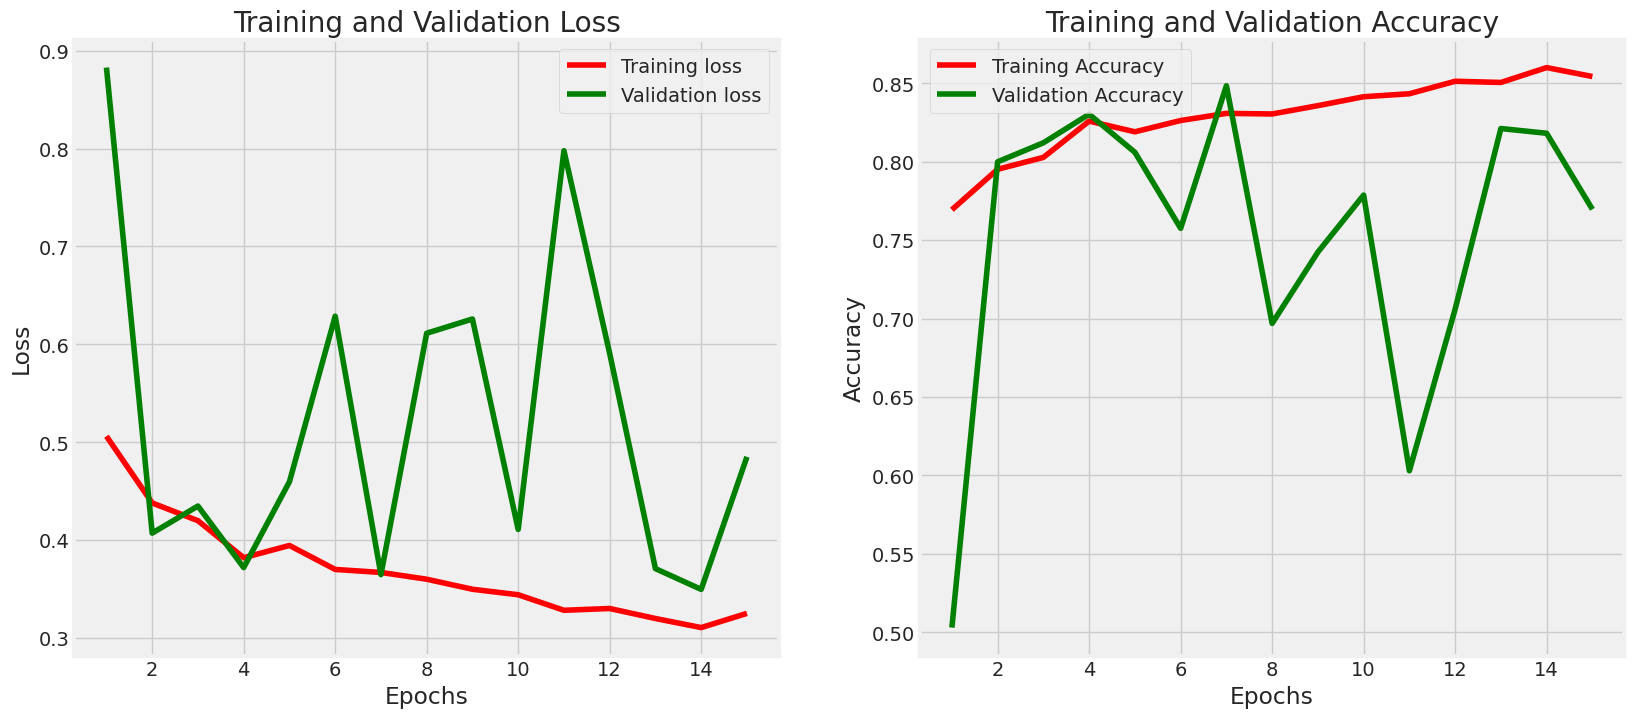

In [ ]:

model_performance(ResNet50_history, epochs)

In [ ]:

model_evaluation(ResNet50_model)

330/330 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.8625 - loss: 0.3004
42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7997 - loss: 0.4167


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.7951 - loss: 0.5034
Train Loss:  0.3231571614742279
Train Accuracy:  0.8490709066390991
--------------------
Validation Loss:  0.48514899611473083
Validation Accuracy:  0.7696969509124756
--------------------
Test Loss:  0.4281366169452667
Test Accuracy:  0.8060606122016907


42/42 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step


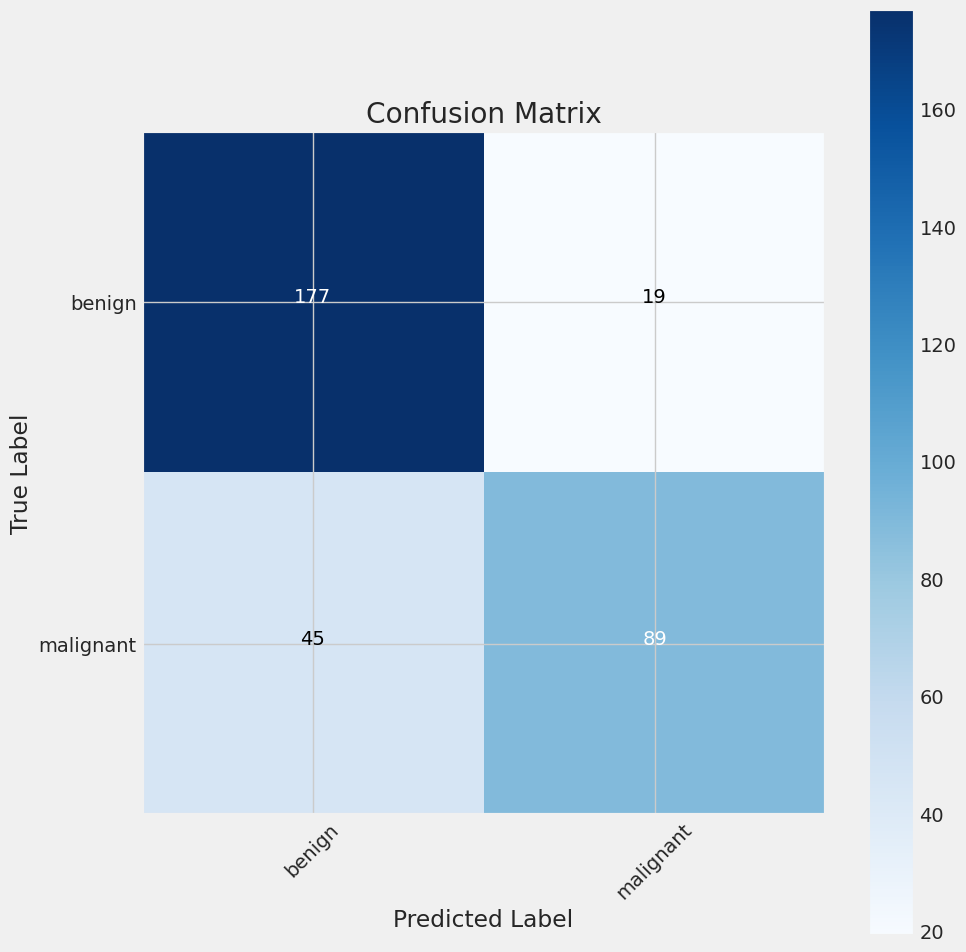

In [ ]:
plot_confusion_matrix(ResNet50_model, test_gen)

In [ ]:
ResNet50_model.save("resnet_mnist.h5")


In [ ]:
from google.colab import files
files.download("resnet_mnist.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>